In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import mygene 
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool, set_tempdir
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl
from structural_peaks import peak_analyzer
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})
Peak_analyzer = peak_analyzer()
mrna_filter = mRNAFilter()

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
set_tempdir(project_path)
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)  
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr6,95156837,95156909,unfragmented.filtered.rvs_peak_23718,49881,1222.34119,4995.90625,4988.11475,1431.0,15.0,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
46480,chr16,223129,223709,unfragmented.filtered.rvs_peak_9669,22708,580.02533,2278.14795,2270.85034,778.0,15.0,.,Unannotated,-,HBA2,Long RNA,0.0,0.0,Antisense
46482,chr16,230338,230855,unfragmented.filtered.rvs_peak_9672,19032,479.86374,1910.37134,1903.22705,690.0,12.0,.,Unannotated,-,HBQ1,Long RNA,0.0,0.0,Antisense
46481,chr16,227335,227447,unfragmented.filtered.rvs_peak_9671,19820,527.45953,1989.25232,1982.00476,672.0,12.0,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
1,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5224,22315,532.39038,2238.97412,2231.52490,539.0,15.0,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense


In [3]:
peak_tsv

'/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv'

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


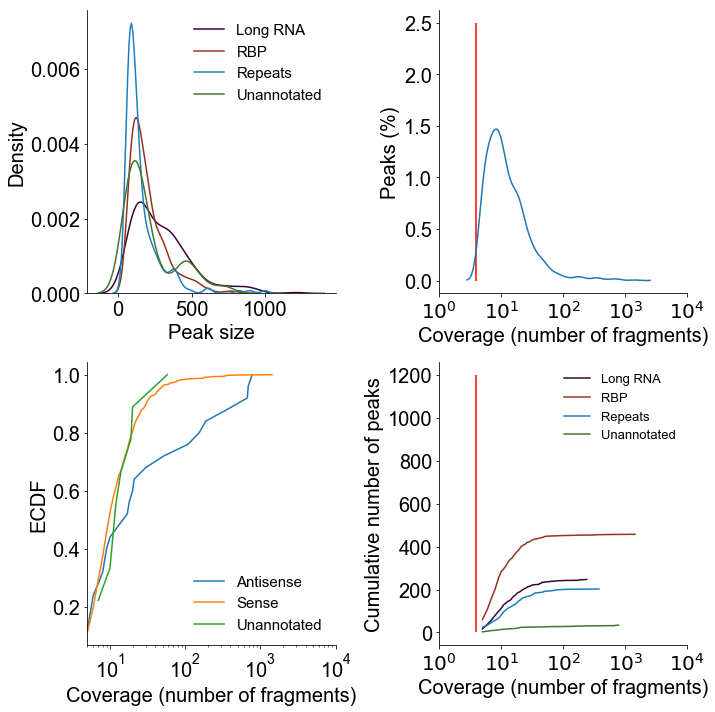

In [10]:
fig = plt.figure(figsize=(10,10))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [11]:
peak_df = peak_df\
    .query('sample_count >= %i & pileup >= %i' %(sample_cutoff, pileup_cutoff))\
    .assign(transcriptome = lambda d: list(map(transcriptome_map, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_exon = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'exon') for chrom, start, end in zip(d.chrom, d.start, d.end)]) \
    .assign(is_transcriptome_peak = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'transcriptome') for chrom, start, end in zip(d.chrom, d.start, d.end)])\
    .pipe(lambda d: d[(d.is_exon=="no") | ((d.is_exon=="yes") & (d.is_transcriptome_peak=="yes"))])
peak_df.shape

(941, 21)

In [12]:
peak_df.query('antisense_gtype == "piRNA"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,transcriptome,is_exon,is_transcriptome_peak
127,chr1,149858525,149858959,unfragmented.filtered.fwd_peak_1766,724,26.61952,77.85442,72.40572,26.0,11.0,...,Long RNA,+,piR-45268,piRNA,1.398234e-78,6.128661e-76,Sense,0.345133,yes,yes
441,chr6,27798953,27799338,unfragmented.filtered.rvs_peak_23147,277,13.62239,32.75265,27.79256,13.0,12.0,...,Long RNA,-,piR-36107,piRNA,1.767462e-33,2.312548e-31,Sense,0.718750,yes,yes
1218,chr6,27782039,27782513,unfragmented.filtered.rvs_peak_23144,114,7.71242,16.04741,11.48852,7.0,6.0,...,Long RNA,-,piR-45268,piRNA,8.965820e-17,4.268259e-15,Sense,0.421053,yes,yes


In [13]:
peak_df.assign(l = lambda d: d.end-d.start).describe()#query('l == 998')

,start,end,score,fc,log10p,log10q,pileup,sample_count,pvalue,FDR,transcriptome,l
count,9.410000e+02,9.410000e+02,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,9.410000e+02,9.410000e+02,941.000000,941.000000
mean,7.205739e+07,7.205760e+07,601.636557,21.681368,65.154274,60.214689,22.469713,7.836344,6.894457e-10,3.158909e-09,0.482276,217.945802
std,5.656907e+07,5.656906e+07,2355.151934,59.474897,235.801458,235.513477,70.674745,2.835714,9.692116e-09,4.295146e-08,0.314147,160.612499
min,1.000000e+04,1.021800e+04,30.000000,4.844020,6.679520,3.094540,5.000000,5.000000,0.000000e+00,0.000000e+00,0.000000,59.000000
25%,2.625037e+07,2.625086e+07,131.000000,7.856510,17.816440,13.183290,7.000000,5.000000,1.070804e-47,2.289506e-45,0.137097,104.000000
50%,5.748584e+07,5.748624e+07,206.000000,10.787640,25.530570,20.698290,10.000000,7.000000,2.947338e-26,2.812760e-24,0.588235,164.000000
75%,1.077791e+08,1.077795e+08,418.000000,18.584220,46.970290,41.824260,18.000000,10.000000,1.526019e-18,8.482123e-17,0.736842,282.000000
max,2.492400e+08,2.492402e+08,49881.000000,1222.341190,4995.906250,4988.114750,1431.000000,15.000000,2.091607e-07,9.130636e-07,1.000000,1207.000000


In [39]:
rbps = set()
for x in peak_df.query('sense_gtype=="RBP"').sense_gname.tolist():
    for rbp in x.split(','):
        rbps.add(rbp)
len(rbps)

89

No handles with labels found to put in legend.


Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


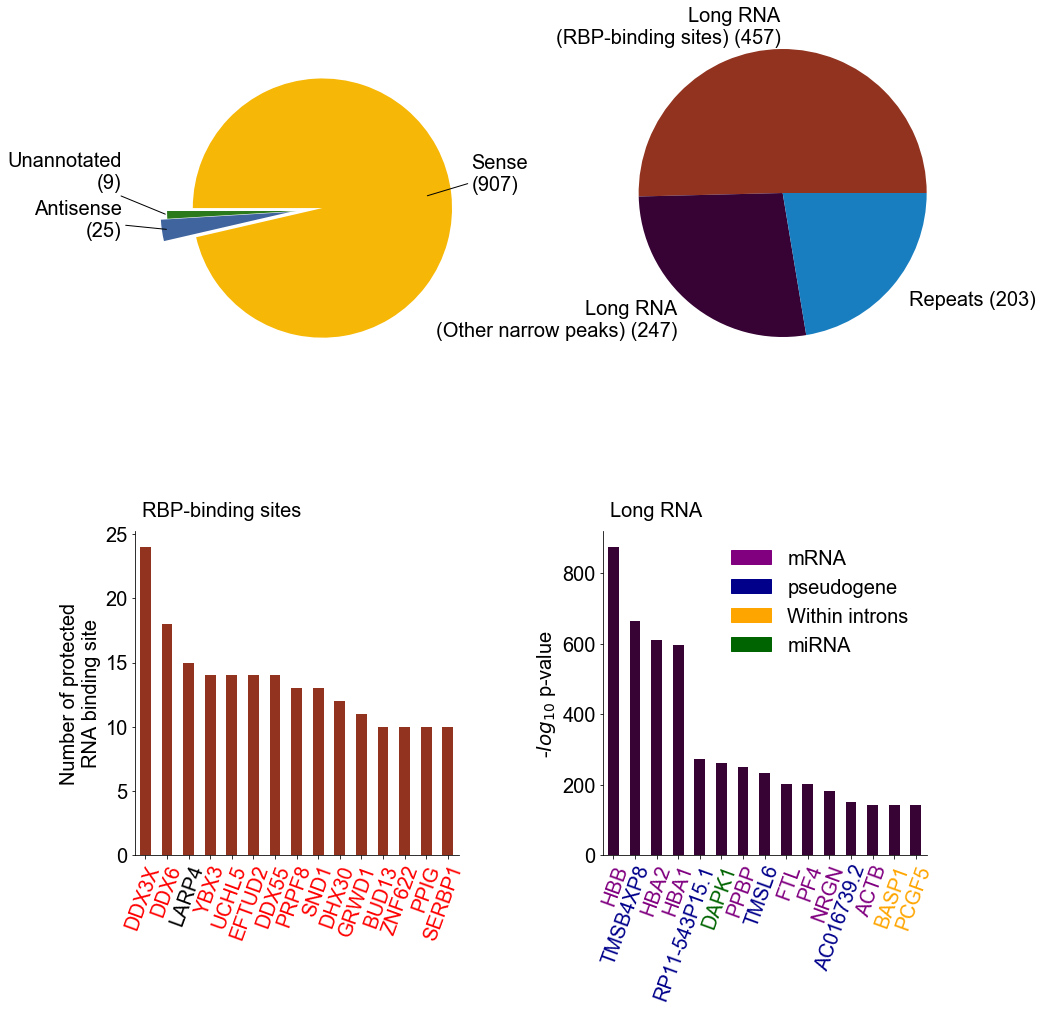

In [14]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.52, 0.45, 0.45])
pie_ax = fig.add_axes([0.55, 0.52, 0.5, 0.5])
#rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
#long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
rbp_ax = fig.add_axes([-0.1, -0.15, 0.45, 0.45])
long_ax = fig.add_axes([0.55, -0.15, 0.45, 0.45])

#misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
#plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
new_ce = color_encoder()
new_ce.encoder = {'mRNA':'purple',
                 'pseudogene':'darkblue',
                 'Within introns':'orange', 
                 'miRNA':'darkgreen'}
for xt in  long_ax.get_xticklabels():
    if xt.get_text() in {'HBB','HBA2','HBA1','PPBP','PF4','FTL','NRGN','ACTB'}:
        xt.set_color(new_ce.encoder['mRNA'])
    elif xt.get_text() in {'TMSB4XP8','TMSL6','AC016739.2','RP11-543P15.1',
                          'RP11-3P17.3'}:
        xt.set_color(new_ce.encoder['pseudogene'])
    elif xt.get_text() in 'DAPK1':
        xt.set_color(new_ce.encoder['miRNA'])
    else:
        xt.set_color(new_ce.encoder['Within introns'])
new_ce.show_legend(ax = long_ax, frameon=False, fontsize=20)
fig.text(-0.09,0.32, 'RBP-binding sites', fontsize=20)
fig.text(0.56,0.32, 'Long RNA', fontsize=20)
#fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [545]:
peak_df.query('sense_gtype=="Long RNA"').sort_values('log10p', ascending=False).head(18)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,transcriptome,is_exon,is_transcriptome_peak
8,chr11,5246693,5246957,unfragmented.filtered.rvs_peak_4180,7384,210.69934,745.11847,738.47791,216.0,15.0,...,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,0.472656,yes,yes
9,chr4,91759630,91760267,unfragmented.filtered.rvs_peak_20611,6576,180.93225,664.16309,657.64606,183.0,15.0,...,Long RNA,-,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,0.658602,yes,yes
12,chr11,5247806,5248342,unfragmented.filtered.rvs_peak_4181,4741,145.55910,480.48441,474.11960,150.0,15.0,...,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,0.487716,yes,yes
13,chr16,222873,223709,unfragmented.filtered.fwd_peak_10315,4716,150.15915,478.07376,471.60309,158.0,15.0,...,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,0.348858,yes,yes
14,chr16,226677,227521,unfragmented.filtered.fwd_peak_10316,4231,130.61864,429.48776,423.10300,134.0,15.0,...,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,0.311222,yes,yes
19,chr12,3320773,3321119,unfragmented.filtered.rvs_peak_5612,2661,84.11353,272.22653,266.13922,85.0,15.0,...,Long RNA,-,TSPAN9,Long RNA,5.935673e-273,1.347310e-269,Sense,0.764045,yes,yes
21,chr9,90294212,90294292,unfragmented.filtered.fwd_peak_29754,2565,93.26810,262.62643,256.50095,104.0,12.0,...,Long RNA,+,.,Unannotated,2.363578e-263,4.994975e-260,Sense,0.000000,no,no
23,chr4,74853681,74853911,unfragmented.filtered.rvs_peak_20463,2431,73.98943,249.24541,243.18486,74.0,14.0,...,Long RNA,-,.,Unannotated,5.683162e-250,1.123543e-246,Sense,0.752577,yes,yes
26,chr20,49456749,49457280,unfragmented.filtered.rvs_peak_16862,2279,75.73525,233.96051,227.95291,77.0,15.0,...,Long RNA,-,BCAS4,Long RNA,1.095191e-234,1.974115e-231,Sense,0.767442,yes,yes
34,chr4,74846558,74847008,unfragmented.filtered.rvs_peak_20457,1954,61.17269,201.37468,195.45937,61.0,14.0,...,Long RNA,-,.,Unannotated,4.220073e-202,6.157891e-199,Sense,0.578313,yes,yes


# Intron #

In [15]:
import pymysql

connection = pymysql.connect(host='genome-mysql.cse.ucsc.edu',
                             user='genome',
                             password='',
                             cursorclass=pymysql.cursors.DictCursor)

query = "SELECT DISTINCT knownGene.name, kgXref.geneSymbol "\
        " FROM hg19.knownGene INNER JOIN hg19.kgXref ON "\
        " knownGene.name = kgXref.kgID  ;"
ucsc_id = pd.read_sql(query, connection) \
    .rename(columns = {'name':'gene_name'})
ucsc_id.head()

,gene_name,geneSymbol
0,uc001aaa.3,DDX11L1
1,uc010nxr.1,DDX11L1
2,uc010nxq.1,DDX11L1
3,uc001aal.1,OR4F5
4,uc001aaq.2,DQ597235


In [16]:
from miRNA_tools import miRNA_test, test_mirtron, fold_intron, gene_conversion
mitest = miRNA_test()
gc = gene_conversion()
pkd = {'RP11-958N24.1':'PKD1P3',
        'RP11-958N24.2':'PKD1P5',
        'RP11-1212A22.1':'PKD1P2',
        'RP11-1212A22.4':'PKD1P4'}


full_peak = pd.read_csv(peak_path + '/unfragmented.unfiltered.tsv', sep='\t')\
    .query('sample_count >= %i' %sample_cutoff)
columns = full_peak.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand','overlapped'])
intron_df = BedTool()\
    .from_dataframe(full_peak)\
    .intersect('/stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz', 
               f= 0.95,F=0.95,wao=True)\
    .to_dataframe(names = columns) \
    .query('intron_chrom != "."')\
    .assign(tid = lambda d: d.intron_gene.str.extract('(ENST[0-9]+)\.',expand=False))\
    .merge(gc.trans.assign(tid = lambda d: d.tid.str.extract('(ENST[0-9]+)',expand=False)), 
           on ='tid', how='left') \
    .assign(gsymbol = lambda d: np.where(d.gsymbol.isin(pkd.keys()),
                                         d.gsymbol.map(pkd),
                                         d.gsymbol))
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz has inconsistent naming convention for record:
GL000192.1	430271	438553	ENST00000621489.1_1	2	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz has inconsistent naming convention for record:
GL000192.1	430271	438553	ENST00000621489.1_1	2	-

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


(204, 24)

In [17]:
intron_df[intron_df.gsymbol.str.contains('PKD')]

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gtype,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,overlapped,tid,gsymbol
6,chr16,16468913,16469003,unfragmented.unfiltered.fwd_peak_10553,1181,44.32756,123.22947,118.15022,45.0,13.0,...,.,chr16,16468913,16469003,ENST00000532739.1_1,27,+,90,ENST00000532739,PKD1P5
8,chr16,18430617,18430707,unfragmented.unfiltered.rvs_peak_9828,1105,42.94662,115.51879,110.53565,44.0,15.0,...,.,chr16,18430617,18430707,ENST00000525846.6_1,28,-,90,ENST00000525846,PKD1P2
10,chr16,15027133,15027223,unfragmented.unfiltered.fwd_peak_10533,979,39.05211,102.93088,97.90172,40.0,13.0,...,.,chr16,15027133,15027223,ENST00000534164.5_1,27,+,90,ENST00000534164,PKD1P3
12,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000262304.8_1,30,-,90,ENST00000262304,PKD1
13,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000415938.7_1,16,-,90,ENST00000415938,PKD1
14,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000423118.5_1,30,-,90,ENST00000423118,PKD1
15,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000471603.6_1,8,-,90,ENST00000471603,PKD1
16,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000480227.5_1,8,-,90,ENST00000480227,PKD1
17,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000483731.5_1,18,-,90,ENST00000483731,PKD1
18,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,.,chr16,2149771,2149861,ENST00000486339.6_1,13,-,90,ENST00000486339,PKD1


In [18]:
intron_df.pipe(lambda d: d[d.gsymbol.str.contains('^RP')])

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gtype,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,overlapped,tid,gsymbol
35,chr16,15221453,15221543,unfragmented.unfiltered.rvs_peak_9787,800,32.60059,84.97578,80.08132,33.0,12.0,...,Long RNA,chr16,15221453,15221543,ENST00000605794.5_1,8,-,90,ENST00000605794,RP11-1186N24.5
92,chr3,52265011,52265142,unfragmented.unfiltered.rvs_peak_18275,299,15.93346,34.54215,29.92273,16.0,8.0,...,.,chr3,52265011,52265142,ENST00000494383.1_4,2,-,131,ENST00000494383,RP11-330H6.5
201,chr16,67685748,67685821,unfragmented.unfiltered.fwd_peak_11157,69,5.76227,11.17973,6.97283,5.0,5.0,...,.,chr16,67685748,67685823,ENST00000334583.10_3,25,+,73,ENST00000334583,RP11-167P11.3
202,chr16,67685748,67685821,unfragmented.unfiltered.fwd_peak_11157,69,5.76227,11.17973,6.97283,5.0,5.0,...,.,chr16,67685748,67685823,ENST00000545661.5_3,26,+,73,ENST00000545661,RP11-167P11.3
203,chr16,67685748,67685821,unfragmented.unfiltered.fwd_peak_11157,69,5.76227,11.17973,6.97283,5.0,5.0,...,.,chr16,67685748,67685823,ENST00000602633.1_1,3,+,73,ENST00000602633,RP11-167P11.3


In [19]:
intron_df.assign(l = lambda d: -d.intron_start+d.intron_end).describe()

,start,end,score,fc,log10p,log10q,pileup,sample_count,intron_start,intron_end,intron_score,overlapped,l
count,2.040000e+02,2.040000e+02,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,2.040000e+02,2.040000e+02,204.000000,204.000000,204.000000
mean,6.552057e+07,6.552066e+07,534.833333,21.099497,58.153265,53.529576,20.823529,8.142157,6.552057e+07,6.552066e+07,9.931373,92.235294,92.495098
std,5.900178e+07,5.900178e+07,1392.327439,37.673453,139.393381,139.227956,39.101337,3.043913,5.900178e+07,5.900178e+07,8.701690,15.034067,15.096895
min,7.184110e+05,7.184880e+05,69.000000,5.762270,11.179730,6.972830,5.000000,5.000000,7.184110e+05,7.184870e+05,1.000000,71.000000,71.000000
25%,1.794019e+07,1.794028e+07,131.000000,8.435360,17.541770,13.167670,8.000000,6.000000,1.794019e+07,1.794028e+07,4.000000,80.000000,80.000000
50%,4.704579e+07,4.704587e+07,286.000000,13.652530,33.270820,28.619090,13.000000,7.000000,4.704579e+07,4.704587e+07,7.500000,90.000000,90.000000
75%,1.000337e+08,1.000338e+08,597.000000,23.528180,64.548500,59.730370,23.000000,11.000000,1.000337e+08,1.000338e+08,13.250000,98.000000,101.000000
max,2.200887e+08,2.200888e+08,13939.000000,376.595250,1399.635130,1393.902340,390.000000,15.000000,2.200887e+08,2.200888e+08,46.000000,131.000000,131.000000


In [20]:
confirmed_intron = intron_df \
    .query('sample_count >= 5 & pileup >=5 ')\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.intron_start, d.intron_end, d.strand))) \
    .assign(seq = lambda d: d.seq.str.upper())\
    .groupby(['chrom','start','end','intron_start','intron_end',
             'strand','peakname','sense_gname','sample_count','pileup','seq'], as_index=False)\
    .agg({'gsymbol': lambda x: x.head(1)})\
    .reset_index(drop=True) \
    .assign(size = lambda d: d.end - d.start) \
    .assign(miRNA = lambda d: list(map(mitest.test, d.chrom, d.start, d.end))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
confirmed_intron.head()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide
0,chr1,54717368,54717466,54717365,54717466,-,unfragmented.unfiltered.rvs_peak_922,RBM22,6.0,8.0,GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGG...,SSBP3,98,No,GT:AG
1,chr1,155288543,155288646,155288544,155288646,+,unfragmented.unfiltered.fwd_peak_1874,RPS5,8.0,16.0,GTGAGGGGAGGTGAGGGACAGCGCGAACCATGTCTGGACAGCGAGG...,FDPS,103,No,GT:AG
2,chr1,161022152,161022229,161022153,161022229,-,unfragmented.unfiltered.rvs_peak_1753,ARHGAP30,13.0,31.0,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,ARHGAP30,77,No,GT:AG
3,chr11,45944515,45944608,45944515,45944608,+,unfragmented.unfiltered.fwd_peak_4964,EFTUD2,10.0,23.0,GTGGGGACCTGGGGTGTGAGCGCCGCGAGCCTGGCGGGCGAGCGGG...,GYLTL1B,93,No,GT:AG
4,chr11,62370150,62370230,62370150,62370230,-,unfragmented.unfiltered.rvs_peak_4676,TROVE2,6.0,7.0,GTGAGGCCGCGGGGATCGCCGGGGTGGGACCGGTGGGCCCGAGGGC...,EML3,80,No,GT:AG


In [21]:
confirmed_intron.query('miRNA=="Yes"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide
10,chr16,2140194,2140285,2140195,2140285,-,unfragmented.unfiltered.rvs_peak_9608,MIR1225,5.0,10.0,GTGGGTACGGCCCAGTGGGGGGGAGAGGGACACGCCCTGGGCTCTG...,PKD1,91,Yes,GT:AG
18,chr16,28855177,28855270,28855176,28855270,-,unfragmented.unfiltered.rvs_peak_9969,MIR4721,10.0,23.0,GTGAGGGCTCCAGGTGACGGTGGGCAGGGTTGAGCCAAGCTCTCCC...,TUFM,93,Yes,GT:AG
28,chr2,220088744,220088827,220088744,220088827,-,unfragmented.unfiltered.rvs_peak_15687,AC068946.1,12.0,28.0,GTGGGCCAGGGCCACAGGCGGGAGCAAGCCGGCTAGCATTCCTGGG...,ATG9A,83,Yes,GT:AG
30,chr22,50356513,50356589,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19202,MIR6821,14.0,122.0,GTGCGTGGTGGCTCGAGGCGGGGGTGGGGGCCTCGCCCTGCTTGGG...,PIM3,76,Yes,GT:AG
33,chr6,31323000,31323093,31323000,31323093,-,unfragmented.unfiltered.rvs_peak_22699,MIR6891,11.0,19.0,GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGG...,HLA-B,93,Yes,GT:AG
36,chr6,31924615,31924718,31924615,31924717,-,unfragmented.unfiltered.rvs_peak_22719,MIR1236,12.0,23.0,GTGAGTGACAGGGGAAATGGGGATGGACTGGAAGTGGGCAGCATGG...,NELFE,103,Yes,GT:AG


In [22]:
confirmed_intron.shape

(43, 15)

In [23]:
seq_dict = defaultdict(list)
for i, row in confirmed_intron.iterrows():
    seq_dict[row['seq']].append(row['chrom']+ ':' + \
                                str(row['start']) + '-'+\
                                str(row['end']) + '('+ \
                                row['sense_gname'] + ')')

In [24]:
list(filter(lambda x: len(x[1])>1,  seq_dict.items()))

[('GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCCTGCCCCTCAGCCTCACCTGTGTGGCCTCCTCTCCTCCACACAG',
  ['chr16:15027133-15027223(RP11-958N24.1)',
   'chr16:15221453-15221543(PKD1P6-NPIPP1)',
   'chr16:16425620-16425710(PKD1P1)',
   'chr16:16468913-16469003(RP11-958N24.2)',
   'chr16:18430617-18430707(RP11-1212A22.1)',
   'chr16:18470719-18470809(RP11-1212A22.4)'])]

In [25]:
confirmed_intron.query('miRNA == "Yes"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide
10,chr16,2140194,2140285,2140195,2140285,-,unfragmented.unfiltered.rvs_peak_9608,MIR1225,5.0,10.0,GTGGGTACGGCCCAGTGGGGGGGAGAGGGACACGCCCTGGGCTCTG...,PKD1,91,Yes,GT:AG
18,chr16,28855177,28855270,28855176,28855270,-,unfragmented.unfiltered.rvs_peak_9969,MIR4721,10.0,23.0,GTGAGGGCTCCAGGTGACGGTGGGCAGGGTTGAGCCAAGCTCTCCC...,TUFM,93,Yes,GT:AG
28,chr2,220088744,220088827,220088744,220088827,-,unfragmented.unfiltered.rvs_peak_15687,AC068946.1,12.0,28.0,GTGGGCCAGGGCCACAGGCGGGAGCAAGCCGGCTAGCATTCCTGGG...,ATG9A,83,Yes,GT:AG
30,chr22,50356513,50356589,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19202,MIR6821,14.0,122.0,GTGCGTGGTGGCTCGAGGCGGGGGTGGGGGCCTCGCCCTGCTTGGG...,PIM3,76,Yes,GT:AG
33,chr6,31323000,31323093,31323000,31323093,-,unfragmented.unfiltered.rvs_peak_22699,MIR6891,11.0,19.0,GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGG...,HLA-B,93,Yes,GT:AG
36,chr6,31924615,31924718,31924615,31924717,-,unfragmented.unfiltered.rvs_peak_22719,MIR1236,12.0,23.0,GTGAGTGACAGGGGAAATGGGGATGGACTGGAAGTGGGCAGCATGG...,NELFE,103,Yes,GT:AG


In [27]:
mirtron = confirmed_intron\
    .groupby('seq', as_index=False)\
    .apply(lambda d: d.nlargest(1,'pileup'))\
    .reset_index(drop=True) \
    .assign(fold = lambda d: d.seq.map(fold_intron))\
    .assign(mirtron_type = lambda d: d.fold.map(test_mirtron)) \
    .assign(fold_abstract = lambda d: d.fold.map(Peak_analyzer.abstract_structure))

In [28]:
mirtron.groupby('mirtron_type').count()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,fold,fold_abstract
mirtron_type,,,,,,,,,,,,,,,,,
3-trim,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
5-trim,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Both trim,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Conventional,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [29]:
confirmed_intron.query('sense_gname == "PRPF8"').seq.tolist()

['GTGAGTGGCCACCATGCGGGGACAGGGGCAGGGGCAGCCCTCACCCACAGCCTCTCACCTGCCTTTGTCCACCCACAG',
 'GTGAGGCTGGGGGGAGGCATAGGTCTTGGCACAGGGAAGTAGAGTTTGGGAGACTCGGCCGTCTGGAGCCTTGTTTCTAACTCACTCCCGCCCTCAAACCTCCGCGGCCTCCCGGACTCAG',
 'GTAAGCAGCTCGTCCCAGCCCTGGGCTCCTGGCTGCCCGCCCAGGATACCTGTCTGACTCACCCTGGGCGCTGGGCTCTGGCTGTTTCCAG']

In [30]:
tablename = figure_path + '/intron_table.csv'
confirmed_intron \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [31]:
confirmed_intron

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide
0,chr1,54717368,54717466,54717365,54717466,-,unfragmented.unfiltered.rvs_peak_922,RBM22,6.0,8.0,GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGG...,SSBP3,98,No,GT:AG
1,chr1,155288543,155288646,155288544,155288646,+,unfragmented.unfiltered.fwd_peak_1874,RPS5,8.0,16.0,GTGAGGGGAGGTGAGGGACAGCGCGAACCATGTCTGGACAGCGAGG...,FDPS,103,No,GT:AG
2,chr1,161022152,161022229,161022153,161022229,-,unfragmented.unfiltered.rvs_peak_1753,ARHGAP30,13.0,31.0,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,ARHGAP30,77,No,GT:AG
3,chr11,45944515,45944608,45944515,45944608,+,unfragmented.unfiltered.fwd_peak_4964,EFTUD2,10.0,23.0,GTGGGGACCTGGGGTGTGAGCGCCGCGAGCCTGGCGGGCGAGCGGG...,GYLTL1B,93,No,GT:AG
4,chr11,62370150,62370230,62370150,62370230,-,unfragmented.unfiltered.rvs_peak_4676,TROVE2,6.0,7.0,GTGAGGCCGCGGGGATCGCCGGGGTGGGACCGGTGGGCCCGAGGGC...,EML3,80,No,GT:AG
5,chr11,71715145,71715270,71715145,71715270,-,unfragmented.unfiltered.rvs_peak_4882,NUMA1,5.0,6.0,GTGAGGCTGGGGCTGAAGGGGGATGAAGCGACGCCCTGGCGGGACC...,NUMA1,125,No,GT:AG
6,chr14,106208132,106208229,106208132,106208229,-,unfragmented.unfiltered.rvs_peak_8561,IGHG1,7.0,15.0,GTGGGACCCGTGGGGTGCGAGGGCCACATGGACAGAGGCCGGCTCG...,IGHG1,97,No,GT:AG
7,chr15,91423004,91423098,91423004,91423096,+,unfragmented.unfiltered.fwd_peak_10127,XPO5,12.0,30.0,GTGAGGGCAGGCTGGCCCGGCAGGCTGGATGTGGAGTTAGGTAGAA...,FURIN,94,No,GT:AG
8,chr16,718411,718488,718411,718487,+,unfragmented.unfiltered.fwd_peak_10270,XPO5,6.0,13.0,GTAAGGGGCACGCCCGCCGCGGGGGTGGGAGCGGGCCCAGCCGGGG...,RHOT2,77,No,GT:AG
9,chr16,2025439,2025529,2025439,2025529,+,unfragmented.unfiltered.fwd_peak_10316,EFTUD2,5.0,5.0,GTGTGTTGGGCCGGGACATGGGCAGGCGGTAGGGGCTGGGGAAGGC...,TBL3,90,No,GT:AG


In [34]:
seqfile = peak_path  + '/unfragmented.intron.fa'
used = defaultdict(int)
with open(seqfile, 'w')  as fa:
    for i, row in confirmed_intron\
            .query('pileup >= 4 & sample_count >= 5' )\
            .filter(['seq','gsymbol','sense_gname'])\
            .drop_duplicates()\
            .iterrows():
        name = row['gsymbol']
        used[name] += 1
        if used[name] > 1:
            print(name, row['sense_gname'])
            name = name + '-%i' %(used[name])
        print('>%s\n%s' %(name, row['seq']), file = fa)
os.system('cat {seqfile} | muscle > {multifile}'.format(seqfile=seqfile,
                                                                 multifile = seqfile.replace('.fa','.multi.fa')))
print('Written: %s' % seqfile.replace('.fa','.multi.fa'))

PKD1 EFTUD2
PKD1P5 RP11-1212A22.4
Written: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.intron.multi.fa
